<a href="https://colab.research.google.com/github/venkat2ram/Keras-and-Tensorflow/blob/master/Gold_price_Tme_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#data_pd=pd.read_csv("/content/Gold_Prices.csv")
data_pd=pd.read_csv("/content/Hasbros_Stock_History.csv")

In [3]:
data_pd.head()

,Day,Price
0,1,0.10535
1,2,0.09877
2,3,0.10974
3,4,0.10755
4,5,0.10535


In [4]:
data_np=data_pd.to_numpy()

In [5]:
data_np

array([[1.0000e+00, 1.0535e-01],
       [2.0000e+00, 9.8770e-02],
       [3.0000e+00, 1.0974e-01],
       ...,
       [1.0214e+04, 7.8510e+01],
       [1.0215e+04, 8.0410e+01],
       [1.0216e+04, 7.9910e+01]])

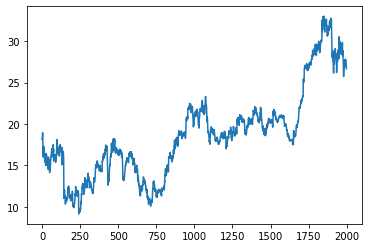

In [6]:
plt.plot(data_np[5000:7000,1])

In [ ]:
decomp=seasonal_decompose(data_np[9283:10036,1],freq=261,model='additive')
decomp.plot()

In [65]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [98]:
time=data_np[:8000,0]
series=data_np[:8000,1]
split_time = 6000
train_time=time[:split_time]
valid_time=time[split_time:]
train_series=series[:split_time]
valid_series=series[split_time:]

In [99]:
window_size=90
train_data=window_dataset(train_series,window_size)
valid_data=window_dataset(valid_series,window_size)

In [100]:
keras.backend.clear_session()

In [101]:
model=tf.keras.Sequential([tf.keras.layers.Dense(1,input_shape=[window_size])])

In [102]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.9),loss=keras.losses.Huber(),metrics=["mae"])

In [103]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 91        
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


In [104]:
model.fit(train_data,epochs=100,validation_data=valid_data)

Epoch 1/100
185/185 [==============================] - 2s 11ms/step - loss: 0.9187 - mae: 1.2913 - val_loss: 1.7103 - val_mae: 2.1634
Epoch 2/100
185/185 [==============================] - 2s 11ms/step - loss: 0.3478 - mae: 0.6385 - val_loss: 0.6940 - val_mae: 1.0773
Epoch 3/100
185/185 [==============================] - 2s 10ms/step - loss: 0.2666 - mae: 0.5262 - val_loss: 1.0446 - val_mae: 1.4897
Epoch 4/100
185/185 [==============================] - 2s 10ms/step - loss: 0.2685 - mae: 0.5222 - val_loss: 0.6037 - val_mae: 0.9842
Epoch 5/100
185/185 [==============================] - 2s 10ms/step - loss: 0.2775 - mae: 0.5489 - val_loss: 0.8417 - val_mae: 1.2645
Epoch 6/100
185/185 [==============================] - 2s 10ms/step - loss: 0.2312 - mae: 0.4988 - val_loss: 0.4711 - val_mae: 0.8217
Epoch 7/100
185/185 [==============================] - 2s 10ms/step - loss: 0.2019 - mae: 0.4414 - val_loss: 0.9735 - val_mae: 1.4222
Epoch 8/100
185/185 [==============================] - 2s 11ms

In [105]:
def model_forecast(model,series,window_size):
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(size=window_size, shift=1,drop_remainder=True)
  dataset=dataset.flat_map(lambda w: w.batch(window_size))
  dataset=dataset.batch(32).prefetch(1)
  lin_forecast=model.predict(dataset)
  return lin_forecast

In [106]:
#lin_forecast=model_forecast(model,series[split_time-window_size:-1],window_size)
lin_forecast=model_forecast(model,data_np[8000-window_size:-1,1],window_size)

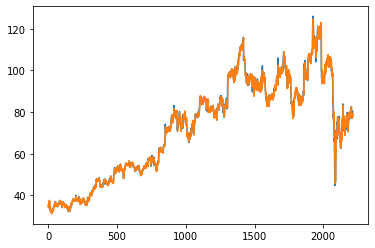

In [107]:
#plt.plot(valid_time,valid_series)
#plt.plot(valid_time,lin_forecast)
plt.plot(data_np[8000:-1,1])
plt.plot(lin_forecast)
plt.show()

In [108]:
lin_forecast.shape

(2216, 1)

In [109]:
data_np[8000:,1].shape

(2216,)